### Step 25. 계산 그래프 시각화

이번 단계에서는 Graphviz를 활용하여 그래프를 시각화해 보겠다.

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot

graphviz는 DOT 언어를 그래프 그림으로 변환시켜준다.

```dot
digraph g {
  x
  y
}
```
위와 같은 형식으로 그래프를 표현하며, 아래 명령어를 터미널에 실행하여, 이미지 파일을 생성한다.

`$ dot sample.dot -T png -o sample.png`

In [ ]:
dot_graph = """
digraph g{
  x
  y
}"""
with open('/content/sample.dot', 'w') as f:
  f.write(dot_graph)

!bash

bash: cannot set terminal process group (63): Inappropriate ioctl for device
bash: no job control in this shell
/content# dot sample.dot -T png -o sample.png
/content# 

/content# exit
exit


이제부터 `Dezero`로 구축한 계산 그래프를 `DOT`언어로 변환하는 함수를 만들어보겠다. `_dot_var` 함수는 변수를 `DOT`언어로 바꾸어준다.

In [ ]:
import numpy as np
from dezero import Variable

def _dot_var(v, verbose=False):
  dot_var = '{} [label="{}", color=orange, style=filled]\n'

  name = '' if v.name is None else v.name
  if verbose and v.data is not None:
    if v.name is not None:
      name += ': '
    name += str(v.shape) + ' ' + str(v.dtype)
  return dot_var.format(id(v), name)

x = Variable(np.random.randn(2, 3))
x.name = 'x'

a = _dot_var(x)
print(a)
a = _dot_var(x, verbose=True)
print(a)

139953756178256 [label="x", color=orange, style=filled]

139953756178256 [label="x: (2, 3) float64", color=orange, style=filled]



아래 `_dot_func` 함수는 `Dezero`의 연산자를 `DOT`언어로 변환해 준다.

In [ ]:
def _dot_func(f):
  dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
  txt = dot_func.format(id(f), f.__class__.__name__)

  dot_edge = '{} -> {}\n'
  for x in f.inputs:
    txt += dot_edge.format(id(x), id(f))
  for y in f.outputs:
    txt += dot_edge.format(id(f), id(y()))
  return txt

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

139953756802640 [label="Add", color=lightblue, style=filled, shape=box]
139953756369488 -> 139953756802640
139953756336464 -> 139953756802640
139953756802640 -> 139953756801552



아래 함수는 위 두 함수를 사용하여 `Dezero`로 만든 계산 그래프를 모두 `DOT`언어로 변환해준다.

In [ ]:
def get_dot_graph(output, verbose=True):
  txt=''
  funcs = []
  seen_set = set()

  def add_func(f):
    if f not in seen_set:
      funcs.append(f)
      seen_set.add(f)

  add_func(output.creator)
  txt += _dot_var(output, verbose)
  while funcs:
    func = funcs.pop()
    txt += _dot_func(func)
    for x in func.inputs:
      txt += _dot_var(x, verbose)

      if x.creator is not None:
        add_func(x.creator)

  return 'digraph g {\n' + txt + '}'

# test
x0 = Variable(np.array(1.0), 'x0')
x1 = Variable(np.array(1.0), 'x1')
y = x0 + x1
y.name = 'y'
print(get_dot_graph(y))

with open('/content/test.dot', 'w') as f:
  f.write(dot_graph)

digraph g {
139953755665808 [label="y: () float64", color=orange, style=filled]
139953755668048 [label="Add", color=lightblue, style=filled, shape=box]
139953755665168 -> 139953755668048
139953935580304 -> 139953755668048
139953755668048 -> 139953755665808
139953755665168 [label="x0: () float64", color=orange, style=filled]
139953935580304 [label="x1: () float64", color=orange, style=filled]
}


이제 복잡한 goldstein 함수를 `Dezero`로 구축한 뒤, 계산그래프로 시각화해보자.

In [ ]:
import numpy as np
from dezero import Variable

def goldstein(x, y):
  z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) *\
  (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
  return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
dot_graph = get_dot_graph(z, verbose=False)
print(dot_graph)

with open('/content/goldstein.dot', 'w') as f:
  f.write(dot_graph)

digraph g {
139953935590288 [label="z", color=orange, style=filled]
139953763791184 [label="Mul", color=lightblue, style=filled, shape=box]
139953756370640 -> 139953763791184
139953928615568 -> 139953763791184
139953763791184 -> 139953935590288
139953756370640 [label="", color=orange, style=filled]
139953928615568 [label="", color=orange, style=filled]
139953763792592 [label="Add", color=lightblue, style=filled, shape=box]
139953763794320 -> 139953763792592
139953763794832 -> 139953763792592
139953763792592 -> 139953928615568
139953763794320 [label="", color=orange, style=filled]
139953763794832 [label="", color=orange, style=filled]
139953763794896 [label="Mul", color=lightblue, style=filled, shape=box]
139953756075024 -> 139953763794896
139953763793552 -> 139953763794896
139953763794896 -> 139953763794320
139953756075024 [label="", color=orange, style=filled]
139953763793552 [label="", color=orange, style=filled]
139953763794256 [label="Add", color=lightblue, style=filled, shape=box]

In [ ]:
!bash

bash: cannot set terminal process group (804): Inappropriate ioctl for device
bash: no job control in this shell
/content/drive/My Drive/Colab Notebooks# cd /content
/content# dot goldstein.dot -T png -o goldstein
/content# 
/content# 
/content# dot goldstein.dot -T png -o goldstein.png
/content# exit
exit


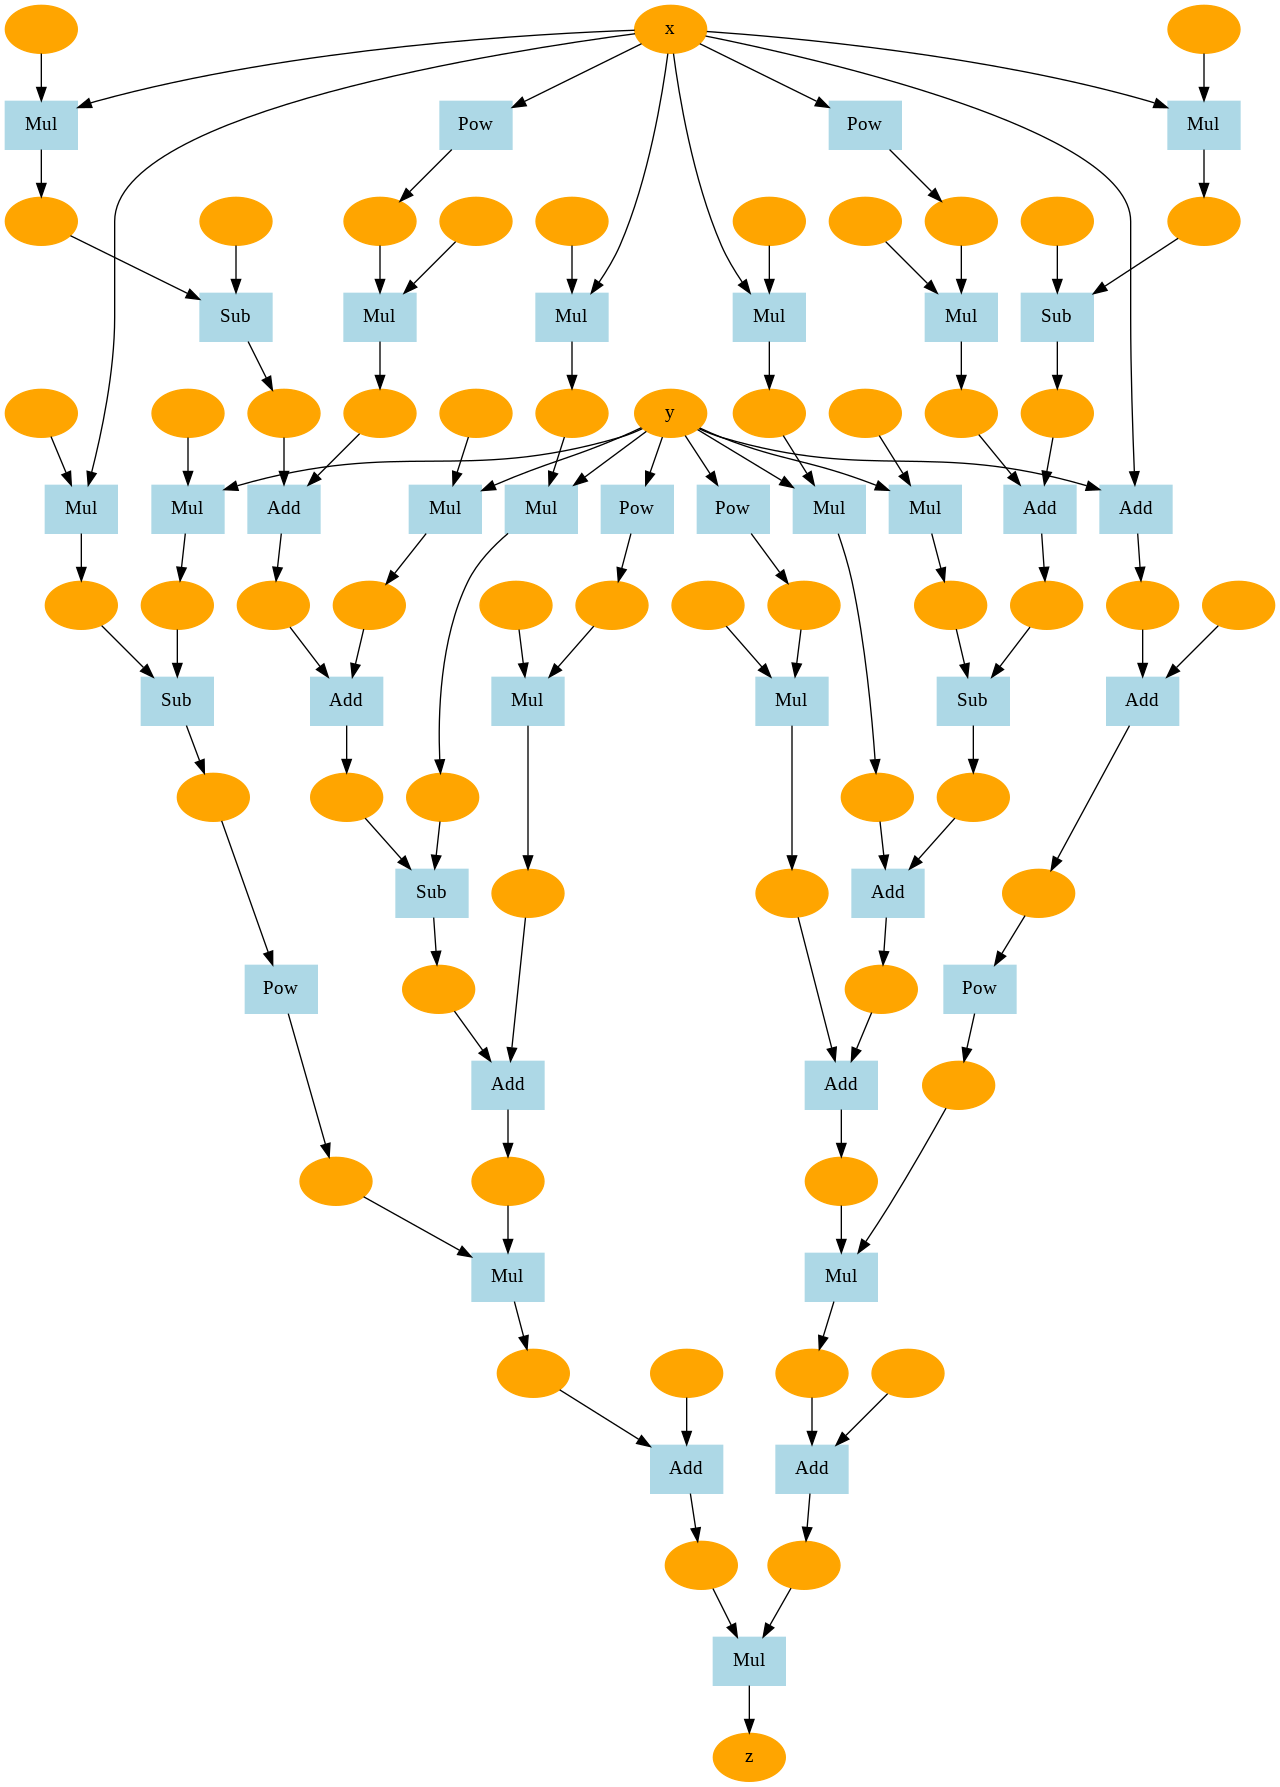

In [ ]:
from IPython import display
to_file = '/content/goldstein.png'
display.Image(filename=to_file)

form IPython import display
to_file = '/content/goldstein.png'

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


### Step 27. 테일러 급수 미분

이번 단계는 sin 함수를 대상으로 해석적 미분과 테일러 급수를 활용한 미분을 시도해 볼것이다. 먼저, 해석적 미분을 활용하여  sin 함수 클래스를 구현해 보도록 하겠다.

In [ ]:
import numpy as np
from dezero import Function
from dezero import Variable

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx

def sin(x):
  return Sin()(x)

# test
x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


이번에는 테일러 급수를 활용한 미분을 시도해보겠다.

테일러 급수는 어떤 함수를 다항식으로 근사하는 방법으로 수식으로는 다음과 같이 표현할 수 있다.

> f(x) = f(a) + f`(a)(x-a) + (1/2!)f``(a)(x-a)<sup>2</sup> + ...

위 식은 점 a에서 f(x)의 테일러 급수이다. 테일러 급수에 의해 f(x)는 점 a를 기점으로 위와 같이 나타낼 수 있으며, 항이 많아질수록 근사의 정확도는 높아진다.

한편 a = 0 일 때의 테일러 급수를 매클로린 전개(Maclaurin's series)라고 한다. 다음과 같다.

> f(x) = f(0) + f`(0)(x) + (1/2!)f``(0)(x)<sup>2</sup> + ...

위 테일러 급수를 활용하여 sin 함수를 표현하면 다음과 같이 표현될 수 있다.

> sin(x) = x / 1! - x<sup>3</sup> / 3! + x<sup>5</sup> / 5! - ... = Sum<sub>{i=0 ~ inf}</sub> [(-1)<sup>i</sup> x<sup>2i+1</sup> / (2i+1)!]

여기서 중요한 점은 i가 커질수록 근사 정밀도가 좋아진다는 것이다.
이제 이러한 테일러 급수를 활용하여 sin 함수를 다시 정의해보겠다.



In [ ]:
import math

def my_sin(x, threshold=0.0001):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2 * i + 1)
    t = c * x ** (2 * i + 1)
    y = y + t
    if abs(t.data) < threshold:
      break
  return y

x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


위 계산 그래프를 시각화해보자.

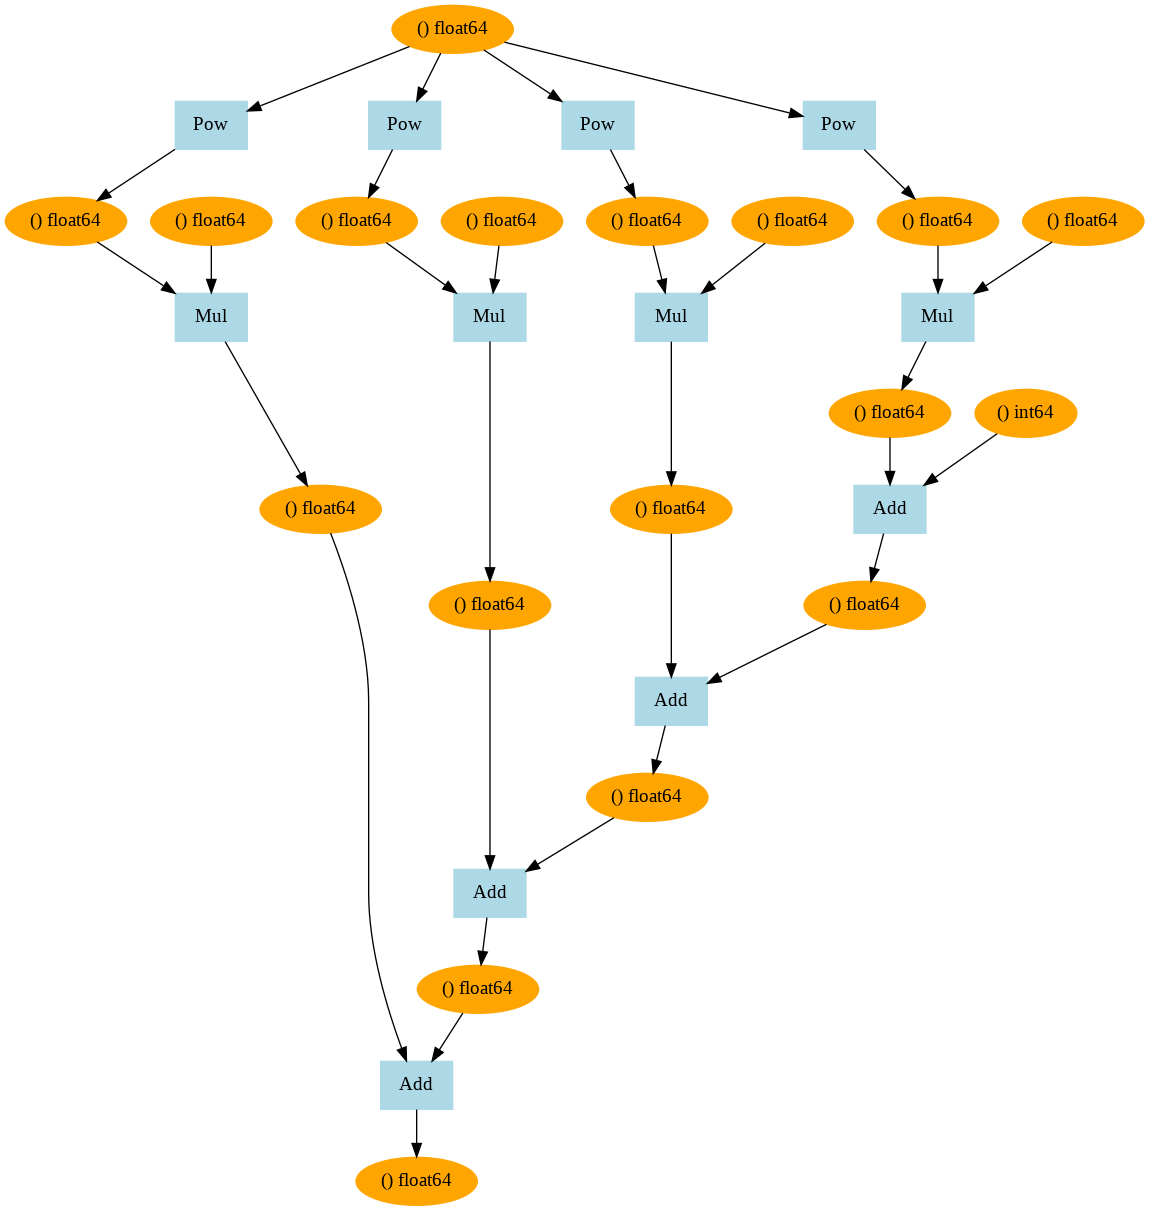

In [ ]:
from dezero.utils import plot_dot_graph

plot_dot_graph(y)

### Step 29. 함수 최적화

이번에는 Dezero의 자동 미분을 활용하여 구체적인 함수를 대상으로 최적화를 진행해보겠다. 

> 최적화란 어떤 함수가 주어졌을 때, 그 최솟값을 반환하는 '입력'을 찾는 일이다. 신경망 학습의 목표도 손실 함수의 출력을 최소화하는 매개변수를 찾는 것이니, 최적화 문제에 속한다.

이번 단계에서는 로젠브록 함수(Rosenbrock function)를 다룬다.

> y = 100(x<sub>0</sub> - x<sub>1</sub><sup>2</sup>)<sup>2</sup> + (1 - x<sub>0</sub>)<sup>2</sup>

먼저 로젠브록 함수를 대상으로 자동미분을 실행해보겠다.

In [ ]:
def rosenbrock(x0, x1):
  y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
  return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


복잡한 형상의 함수라면 기울기가 가리키는 방향에 반드시 최댓값이 존재한다고는 볼 수 없다. 그러나 국소적으로 보면 기울기는 함수의 출력을 가장 크게 하는 방향을 나타낸다. 그래서 기울기 방향으로 일정 거리만큼 이동하여 다시 기울기를 구하는 작업을 반복하면 점차 원하는 지점에 접근하리라 기대할 수 있으며, 이것을 '경사 하강법(gradient descent)'라고 한다.

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

lr = 0.001
iters = 1000

for i in range(iters):
  print(x0, x1)
  y = rosenbrock(x0, x1)

  x0.cleargrad() # 미분값 초기화
  x1.cleargrad()
  y.backward()

  x0.data -= lr * x0.grad
  x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

### Step 29. 뉴턴 방법으로 푸는 최적화

앞의 단계에서는 경사 하강법으로 최적화를 진행했으나, 일반적으로 수렴이 느리다는 단점이 있다. 그중에서 가장 유명한 방법이 뉴턴 방법(Newton's method)이다. 

뉴턴 방법을 알아보기 전에, 테일러 급수를 다시 한번 떠올려 보자.

> f(x) = f(a) + f`(a)(x-a) + (1/2!)f``(a)(x-a)<sup>2</sup> + ...

테일러 급수는 1차 미분, 2차 미분, 3차 미분, 형태로 항상 증가하는데, 증가하는 걸 어느 시점에 중단하면 f(x)를 근사적으로 나타낼 수 있다.

> f(x) ~= f(a) + f`(a)(x-a) + (1/2)f``(a)(x-a)<sup>2</sup>

위 식처럼 f(x)를 2차 함수의 형태로 미분할 수 있는데, 중요한 점은 2차 함수 같은 경우 최솟값을 해석적으로 구할 수 있다는 점이다.

> x<sub>min</sub> = a - f`(a) / f``(a)

따라서 a의 위치를 f`(a) / f``(a) 만큼 갱신하면 되는 것이다.

> * 경사 하강법 : x = x - lr * f`(x)
* 뉴턴 방법 : x = x - f`(x) / f``(x)

위 비교에서 알 수 있는 가장 중요한 것은, 경사 하강법 같은 경우 학습률을 사람이 수동으로 설정해 주었지만, 뉴턴 방법 같은 경우 이차미분을 활용하여 (1 / f``(x))로 자동으로 조정한다는 것이다.

그렇다면, 이 뉴턴 방법으로 구체적인 문제를 하나 풀어보도록 하자.

In [ ]:
def f(x):
  y = x ** 4  - 2 * x ** 2
  return y

def gx2(x):
  return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward()

  x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 31. 고차 미분

지금까지는 고차 미분을 수동으로 구현하였으나, 이제부터는 Dezero를 업그레이드 시켜서, 고차미분을 자동화 할 것이다.

고차미분을 자동화시키는 법은 단순한데, 역전파를 할 때, 역전파에 대한 계산 그래프를 구축하면 된다. 따라서 다음과 같은 간단한 수정작업을 거친다.

* Variable의 self.grad에 대입되는 객체의 타입을 Variable()로 설정한다.
```python
class Variable:

  ...
  def backwrad(self, retain_grad = False):
    if self.grad is None:
      self.grad = Variable(np.ones_like(self.data))

  ...
```
* Mul, Div, Pow 연산자의 backward() 함수를 수정한다.
```python
class Mul(Function):
  ...
  def backward(self, gy):
    x0 = self.inputs[0]
    x1 = self.inputs[1]
    return gy * x1, gy * x0
```
* 역전파 비활성화 모드를 추가한다. 이 모드를 활성화하면 역전파를 할 때, 계산그래프가 만들어지지 않는다.
```python
class Variable:

  ...
  def backwrad(self, retain_grad = False, create_graph = False):
    ...
    while funcs:
      f = heapq.heappop(funcs)
      gys = [output().grad for output in f.outputs]

      with using_config('enable_backprop', create_graph):
        gxs = f.backward(*gys)
        if not instanceof(gxs, tuple):
          gxs = (gxs,)

        for x, gx in zip(f.inputs, gxs):
          if x.grad is None:
            x.grad = gx
          else:
            x.grad = x.grad + gx

          if x.creator is not None:
            add_func(x.creator)
  ...
```

### Step 33. 뉴턴방법으로 푸는 최적화



In [ ]:
import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad) # 1차 미분

gx = x.grad # 2차 미분
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


In [ ]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward(create_graph=True)
  gx = x.grad
  x.cleargrad()

  gx.backward()
  gx2 = x.grad

  x.data -= (gx.data / gx2.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### Step 34. 함수 고차 미분

지금까지 구현한 Dezero의 고차미분 기능을 활용하여, `sin` 함수를 고차미분 해보도록 하겠다. 그러기 위해서는 함수 자체를 구현해야 한다.

In [ ]:
import numpy as np
from dezero.core import Function

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * cos(x)
    return gx

def sin(x):
  return Sin()(x)

class Cos(Function):
  def forward(self, x):
    y = np.cos(x)
    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * -sin(x)
    return gx

def cos(x):
  return Cos()(s)

이제 `sin`함수를 2, 3, 4차 미분까지 실행해보겠다.

In [ ]:
import dezero.functions as F
from dezero import Variable
import numpy as np

x = Variable(np.array(1.0))
y = F.sin(x)
y.backward(create_graph=True)

for i in range(3):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)
  print(x.grad)

variable(-0.8414709848078965)
variable(-0.5403023058681398)
variable(0.8414709848078965)


앞의 코드를 확장하여, `sin`함수의 미분 결과를 그래프로 그려보겠다.

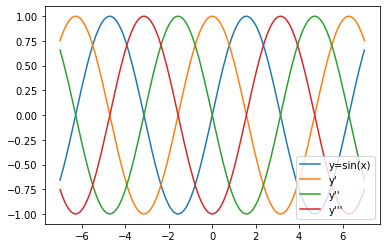

In [ ]:
import matplotlib.pyplot as plt

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
  logs.append(x.grad.data)
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
  plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

# Step 35 고차 미분 그래프

이번에는 tanh 함수를 구현해보고, 고차미분을 실행해보겠다.

In [ ]:
class Tanh(Function):
  def forward(self, x):
    y = np.tanh(x)
    return y

  def backward(self, gy):
    y = self.outputs[0]()
    gx = gy * (1 - y * y)
    return gx

def tanh(x):
  return Tanh()(x)

tanh 함수에 대한 고차 미분 계산 그래프를 시각화해보겠다.

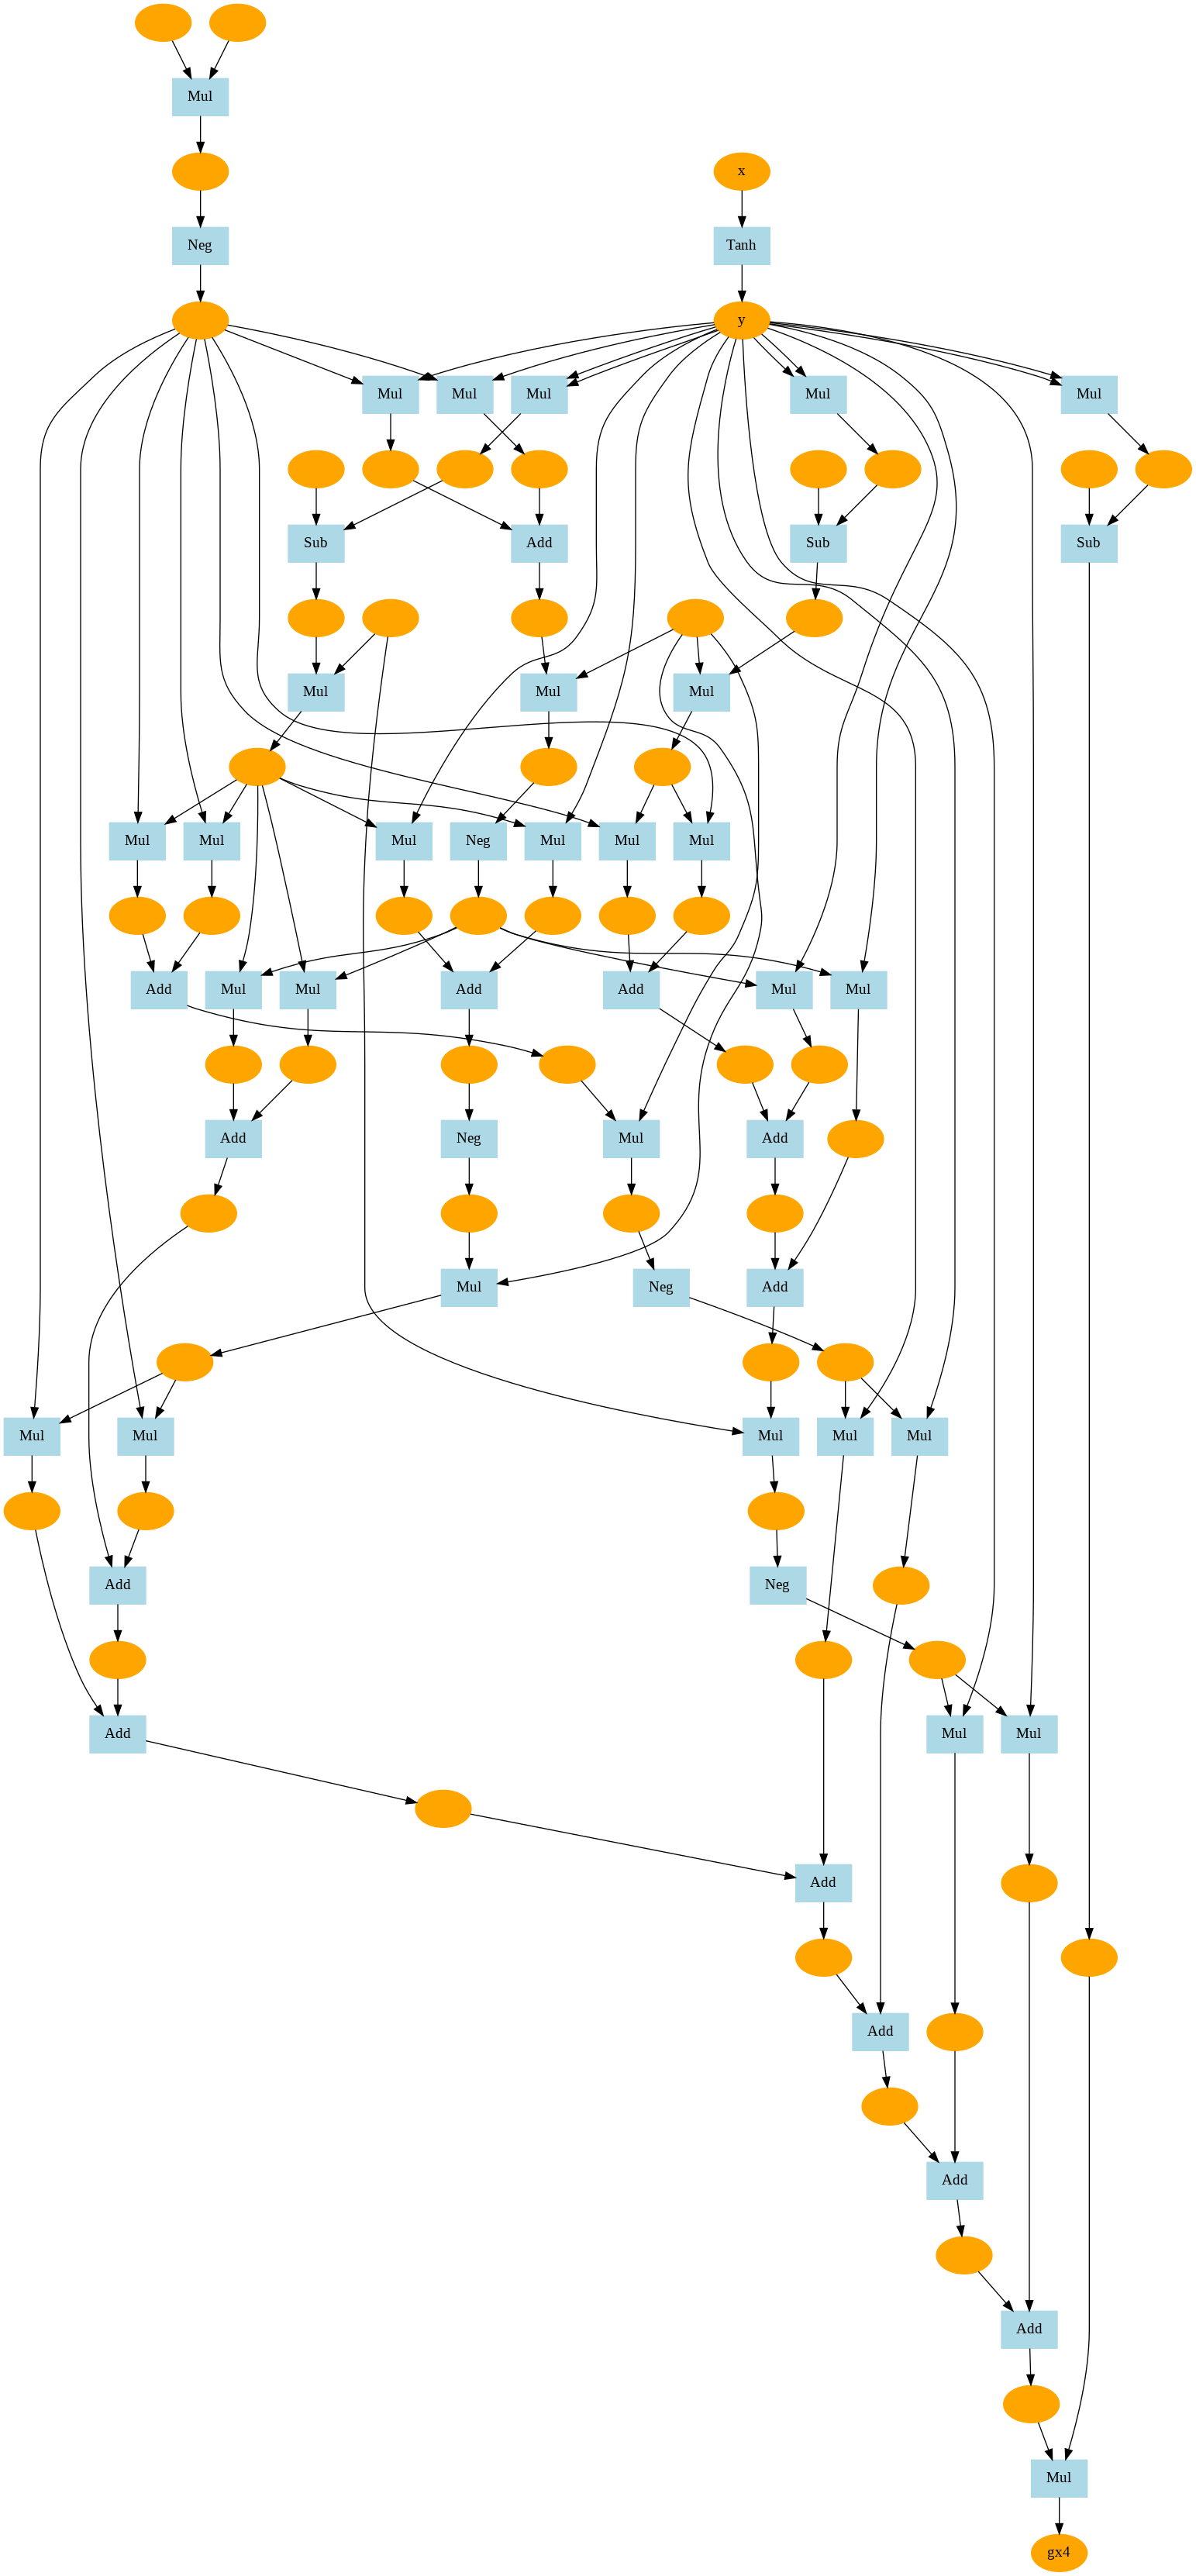

In [ ]:
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0), 'x')
y = F.tanh(x)
y.name = 'y'
y.backward(create_graph=True)

iters = 3

for i in range(iters):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

gx = x.grad # 2차 미분 결과
gx.name = 'gx' + str(iters + 1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')